In [1]:
import numpy as np
from collections import defaultdict
from pprint import pprint
import sys, os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt

from os.path import expanduser
home = expanduser("~")
model_home = os.path.join(home, 'src/model/ca3_biophysical/')
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/utils'))
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/cells'))
sys.path.append(os.path.join(home, 'bin/nrnpython3/lib/python'))

from mpi4py import MPI
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from neuron import h
from neuron.units import ms, mV

font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


%load_ext autoreload
%autoreload 2

numprocs=1


In [2]:

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [3]:

delay = 500.
dt = 0.1

params_path = os.path.join(model_home, 'params')
ar = Arena(os.path.join(params_path, 'arenaparams.yaml'))
ar.generate_population_firing_rates()
ar.generate_cue_firing_rates('LEC', 1.0)
print(ar.params['Arena'])
cued = True


{'arena size': 200, 'mouse speed': 30, 'bin size': 0.1, 'lap information': {'nlaps': 10, 'is spatial': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'random seed': 1000000, 'frac place': 0.75}


In [4]:
ar.generate_spike_times('MF', dt=dt, delay=delay)
ar.generate_spike_times('MEC', dt=dt, delay=delay)
ar.generate_spike_times('LEC', dt=dt, delay=delay, cued=cued)
ar.generate_spike_times('Background', dt=dt, delay=delay)


[10 27  8 17  2 14  1  3  5 26 11  0  9 22 20  4 18 15 24 29  6 19 23 13
 12  7 25 16 21 28]


In [5]:
total_fr = None
for i in range(400):
    fr = ar.cell_information['MF']['cell info'][i]['firing rate']
    if i == 0:
        total_fr = np.copy(fr)
    else:
        total_fr += fr

plt.figure()
plt.plot(arena_map, total_fr)
plt.show()

   
total_fr = None
for i in range(200):
    fr = ar.cell_information['MEC']['cell info'][i]['firing rate']
    if i == 0:
        total_fr = np.copy(fr)
    else:
        total_fr += fr
        
plt.figure()
plt.plot(arena_map, total_fr)
plt.title('MEC: %i' % np.max(total_fr))
plt.show();





NameError: name 'arena_map' is not defined

<Figure size 640x480 with 0 Axes>

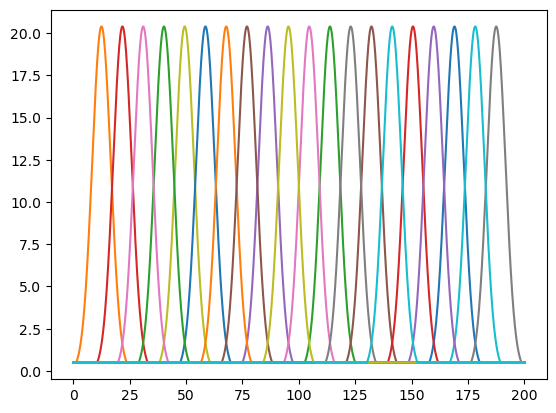

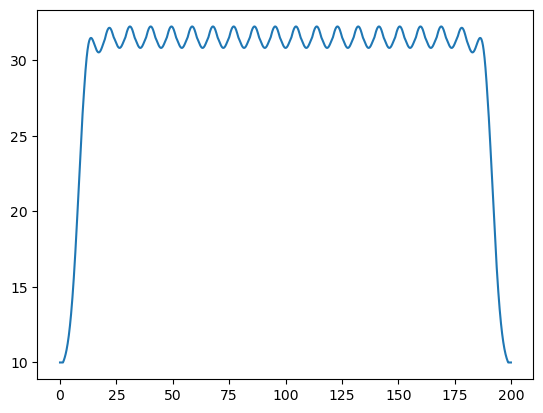

In [6]:
fr = ar.cell_information['LEC']['cell info'][0]['firing rate']

edge = 12.5
nlaps = 20
lp    = 1

arena_map  = np.arange(0, 200,step=0.1)
cued_positions  = np.linspace(edge, 200-edge, nlaps*lp)
random_cue_locs = np.arange(len(cued_positions))
np.random.shuffle(random_cue_locs)

frs_all = []
for i in range(nlaps):
    random_position = cued_positions[random_cue_locs[i]]
    to_roll = int( ( 100. - random_position) / 0.1 )
    fr_rolled = np.roll(fr, to_roll)
    frs_all.append(fr_rolled)

frs_all = np.asarray(frs_all)

plt.figure()
for i in range(nlaps):
    plt.plot(arena_map, frs_all[i])
    
plt.figure()
plt.plot(arena_map,np.sum(frs_all, axis=0))

plt.show();

In [7]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 10


In [8]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram(os.path.join(params_path, 'circuitparams.yaml'), place_information)
internal_kwargs = {}
internal_kwargs['place information'] = diagram.place_information
internal_kwargs['cue information'] = diagram.place_information
diagram.generate_internal_connectivity(**internal_kwargs)

place_ids = diagram.place_information[0]['place']
cue_ids = diagram.place_information[0]['not place']

print(list(diagram.place_information.keys()))
external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101, 102]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [100, 101, 102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)

diagram.generate_septal_connectivity()




[0]
src_id = 100 dst_pop_id = 0 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id in external_place_ids = True 
src_id = 100 dst_pop_id = 1 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id in external_place_ids = True 
src_id = 101 dst_pop_id = 0 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id in external_place_ids = True 
src_id = 101 dst_pop_id = 1 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id in external_place_ids = True 
src_id = 102 dst_pop_id = 0 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id in external_place_ids = True 
src_id = 102 dst_pop_id = 1 external_place_ids = [100, 101, 102] external_cue_ids = [100, 101, 102] src_id in external_cue_ids = True src_id 

In [9]:
print(sorted(cue_ids))
print(len(cue_ids))

[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]
48


In [10]:
print(sorted(place_ids))

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]


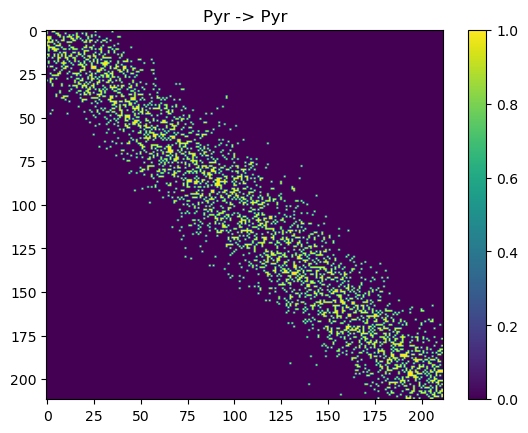

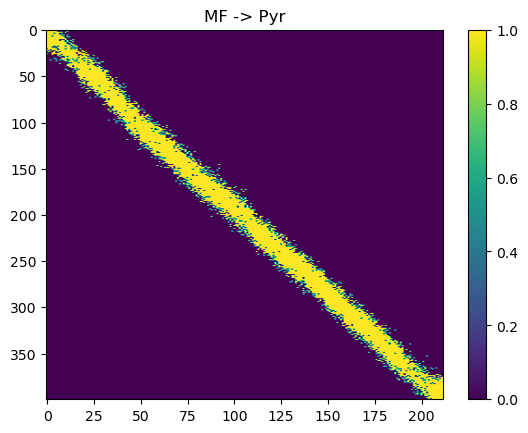

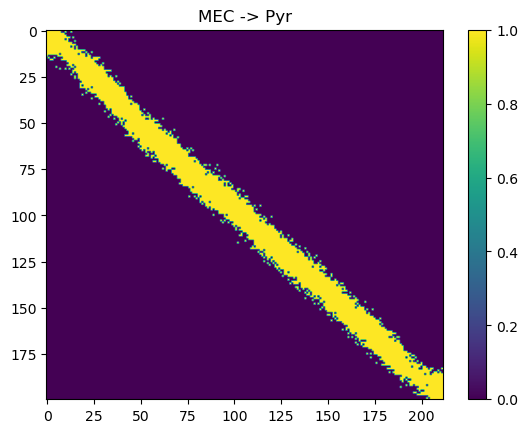

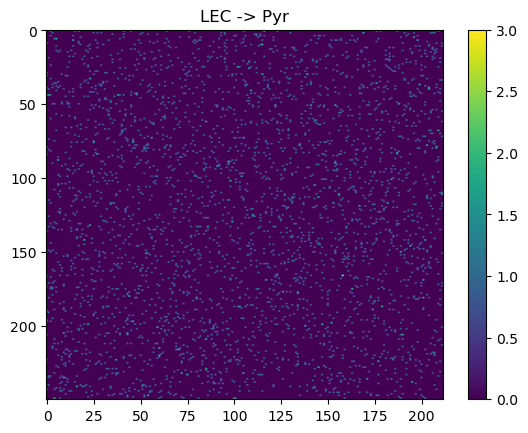

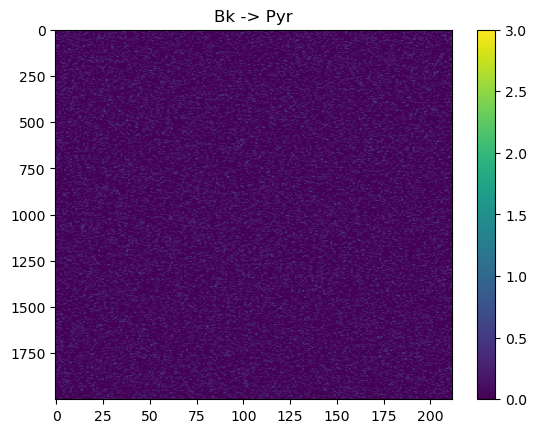

5005
7904
24720


In [11]:
plt.figure()
plt.title("Pyr -> Pyr")
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.title("MF -> Pyr")
plt.imshow(diagram.external_adj_matrices[100][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("MEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[101][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("LEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[102][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Bk -> Pyr")

plt.imshow(diagram.external_adj_matrices[103][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


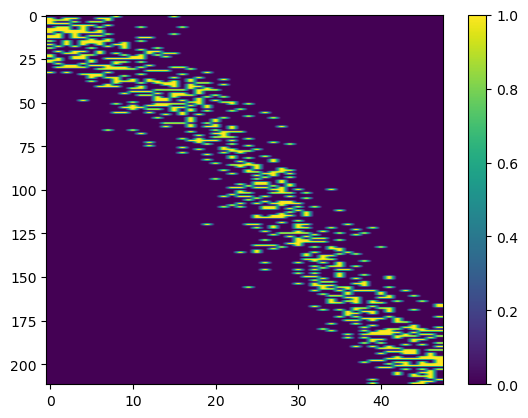

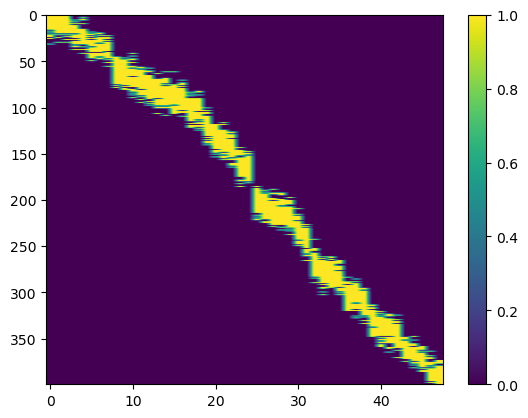

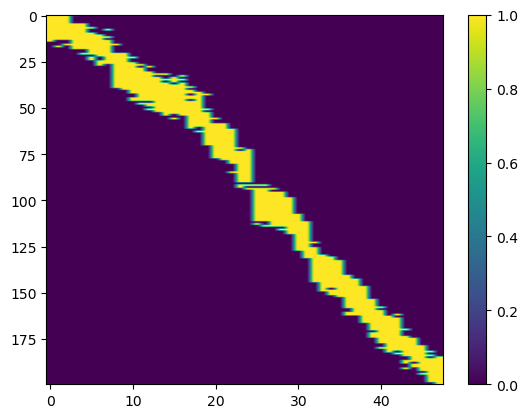

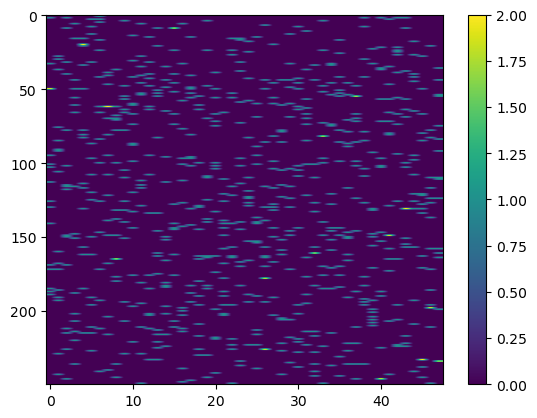

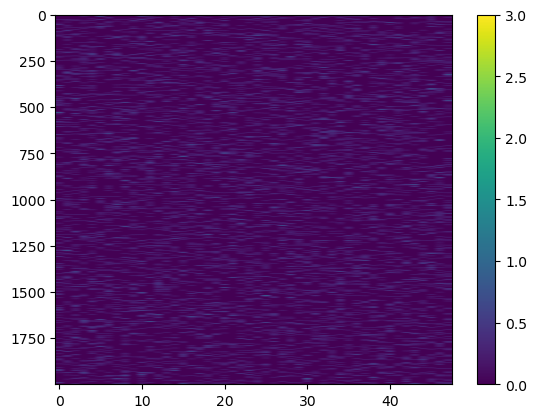

5005
7904
24720


In [12]:
plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[101][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[102][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[103][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


In [13]:
def pull_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

mf_spike_times  = pull_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

In [14]:
np.nonzero(diagram.external_adj_matrices[101][0][115])[0]

array([127, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161])

In [15]:
ext_spike_times = np.load("../data/ext_spikes_0801-cue-ee-ei-nlaps-10.npz")
ext_spike_times = { int(k): v for k,v in ext_spike_times.items() }

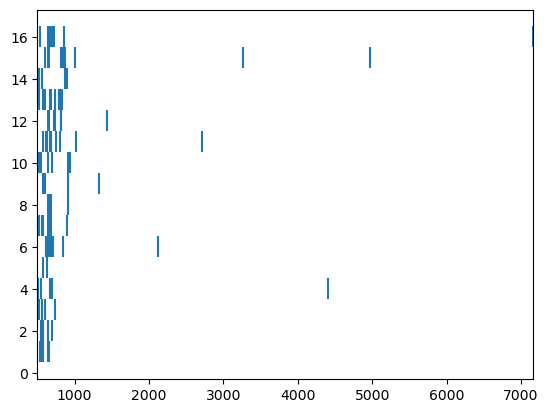

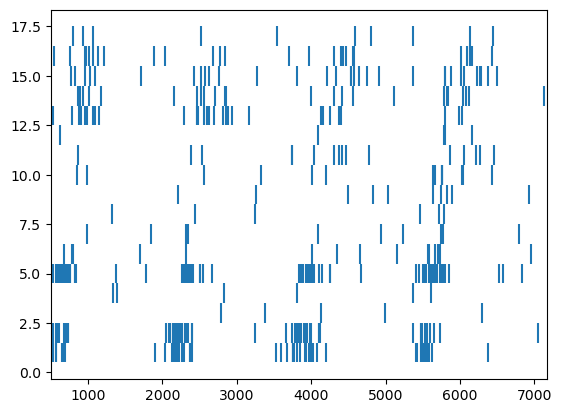

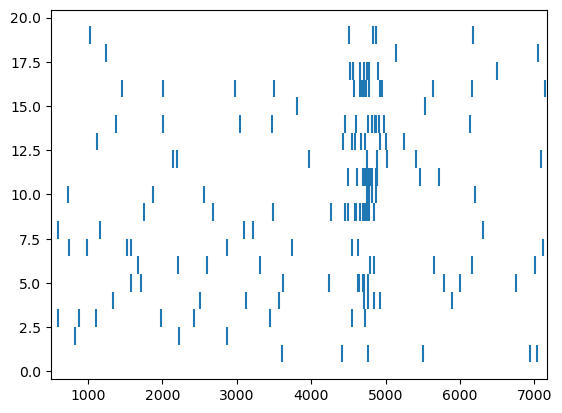

In [16]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

place_cells = diagram.place_information[0]['place']

ctype_offset = diagram.external_information['MF']['ctype offset']
for z in place_cells[10:11]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][z])[0]
    i = 0
    for src_id in src_ids:
        
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
            
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in place_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in place_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    


[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]


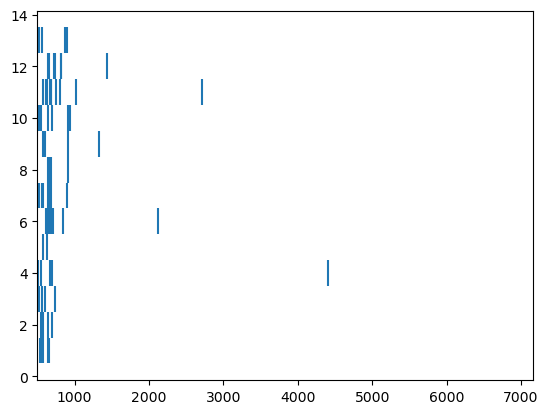

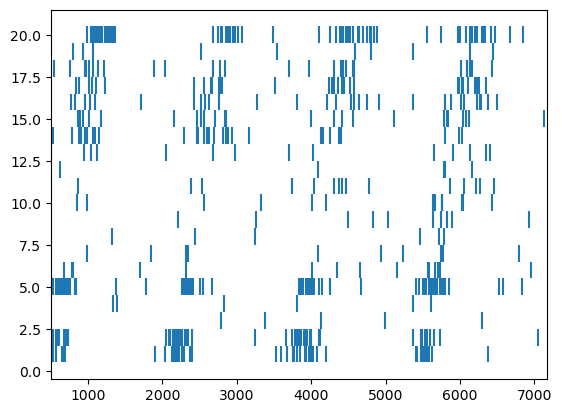

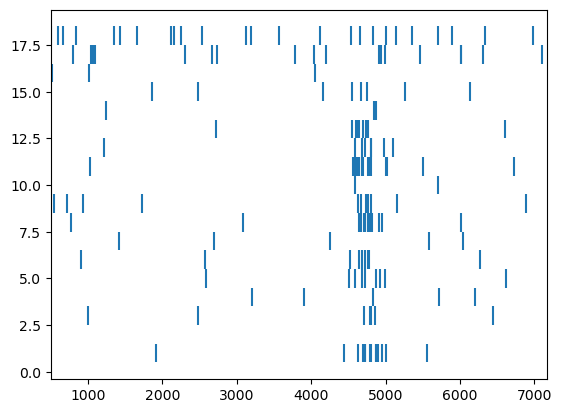

In [17]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

cue_cells = diagram.place_information[0]['not place']
print(cue_cells)

ctype_offset = diagram.external_information['MF']['ctype offset']

for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid in ext_spike_times:
            src_gid_spikes = ext_spike_times[src_gid]
            if len(src_gid_spikes) > 0:
                src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                       src_gid_spikes <= finish))]
                plt.vlines(list(src_spikes), i+0.5, i+1.5)
                i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

    


In [18]:
nplaces = len(place_ids)

# for i in range(55,65):
#     plt.figure()
#     plt.plot(np.asarray(t_vec), np.asarray(exc_v_vecs)[place_ids][i][:].T)
#     plt.ylim([-75,-30])
#     plt.show()
    
nspikes = []
ecells = circuit.neurons[0]
spiking_gids = []
for pid in place_ids:
    spks = np.asarray(list(ecells[pid].spike_times))
    spks = spks[spks>500]
    nspikes.append(len(spks))
    if len(nspikes) > 0:
        spiking_gids.append(pid)
print(f'nspikes: {nspikes}')
print(f'spiking_gids: {spiking_gids}')

    
plt.figure()
plt.hist(nspikes, bins=np.arange(0,np.max(nspikes)))
print(np.sort(nspikes), nplaces)


low_spike_pos = []
for (i,nspk) in enumerate(nspikes):
    if nspk == 0:
        low_spike_pos.append(diagram.wiring_information['ca3pyr']['cell info'][place_ids[i]]['soma position'])
    
plt.figure()
plt.plot(low_spike_pos)
plt.show();

NameError: name 'circuit' is not defined

In [24]:
spiking_gids[np.argmax(nspikes)]


NameError: name 'spiking_gids' is not defined

In [19]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram

lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
lfp_mean = lfp_np.mean(axis=0)

lfp_filtered = butter_bandpass_filter(lfp_mean, 2.0, 250.0, 2000., order=3)

start = np.where(np.asarray(t_vec) > time_for_single_lap*14+500)[0][0]
end   = np.where(np.asarray(t_vec) < time_for_single_lap*15+500)[0][-1]


plt.figure()
plt.plot(list(t_vec)[2000:5000], lfp_filtered[2000:5000])


f, p = welch(lfp_filtered[start:end], fs=2000., nperseg=2048)
plt.figure()
plt.plot(f[1:100], p[1:100])
plt.show()

lfp_f, lfp_t, lfp_S = spectrogram(lfp_mean[1000:end], fs=2000., nperseg=512)
fs, fe = np.where(lfp_f >= 2.0)[0][0], np.where(lfp_f <= 60)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)
plt.figure(figsize=(20,4))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
plt.colorbar()
plt.show()

NameError: name 'circuit' is not defined

In [20]:
exc_v_vecs = { int(k): v for k,v in np.load("../data/v_vecs_0801-cue-ee-ei-nlaps-10.npz").items() }
dt = 0.025
t_end = exc_v_vecs[0].shape[0] * dt*2
t_vec = np.arange(0., t_end, dt*2)

In [21]:
t_end

67166.65000000001

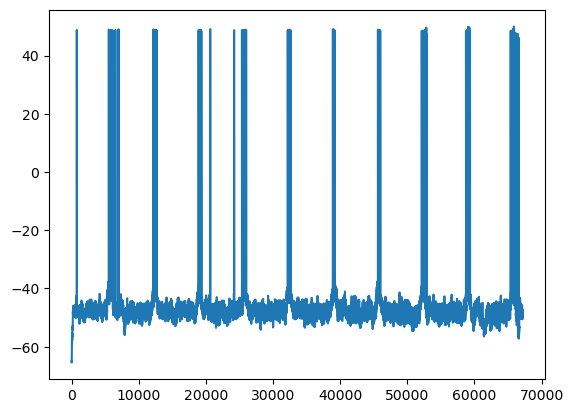

In [22]:
exc_v_vec_200 = exc_v_vecs[200]
plt.plot(t_vec, exc_v_vec_200)
plt.show();

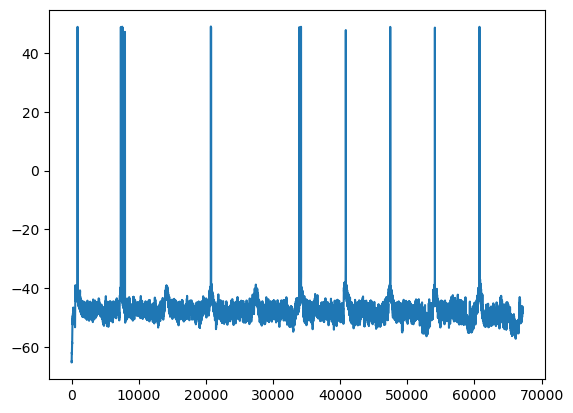

In [23]:
exc_v_vec_0 = exc_v_vecs[0]
plt.plot(t_vec, exc_v_vec_0)
plt.show();

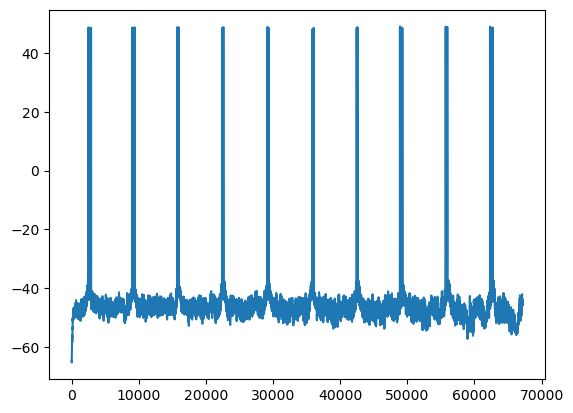

In [24]:
exc_v_vec_77 = exc_v_vecs[77]
plt.plot(t_vec, exc_v_vec_77)
plt.show();

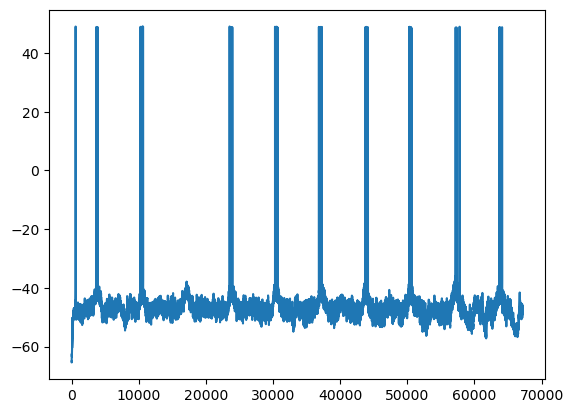

In [27]:
exc_v_vec_127 = exc_v_vecs[127]
plt.plot(t_vec, exc_v_vec_127)
plt.show();

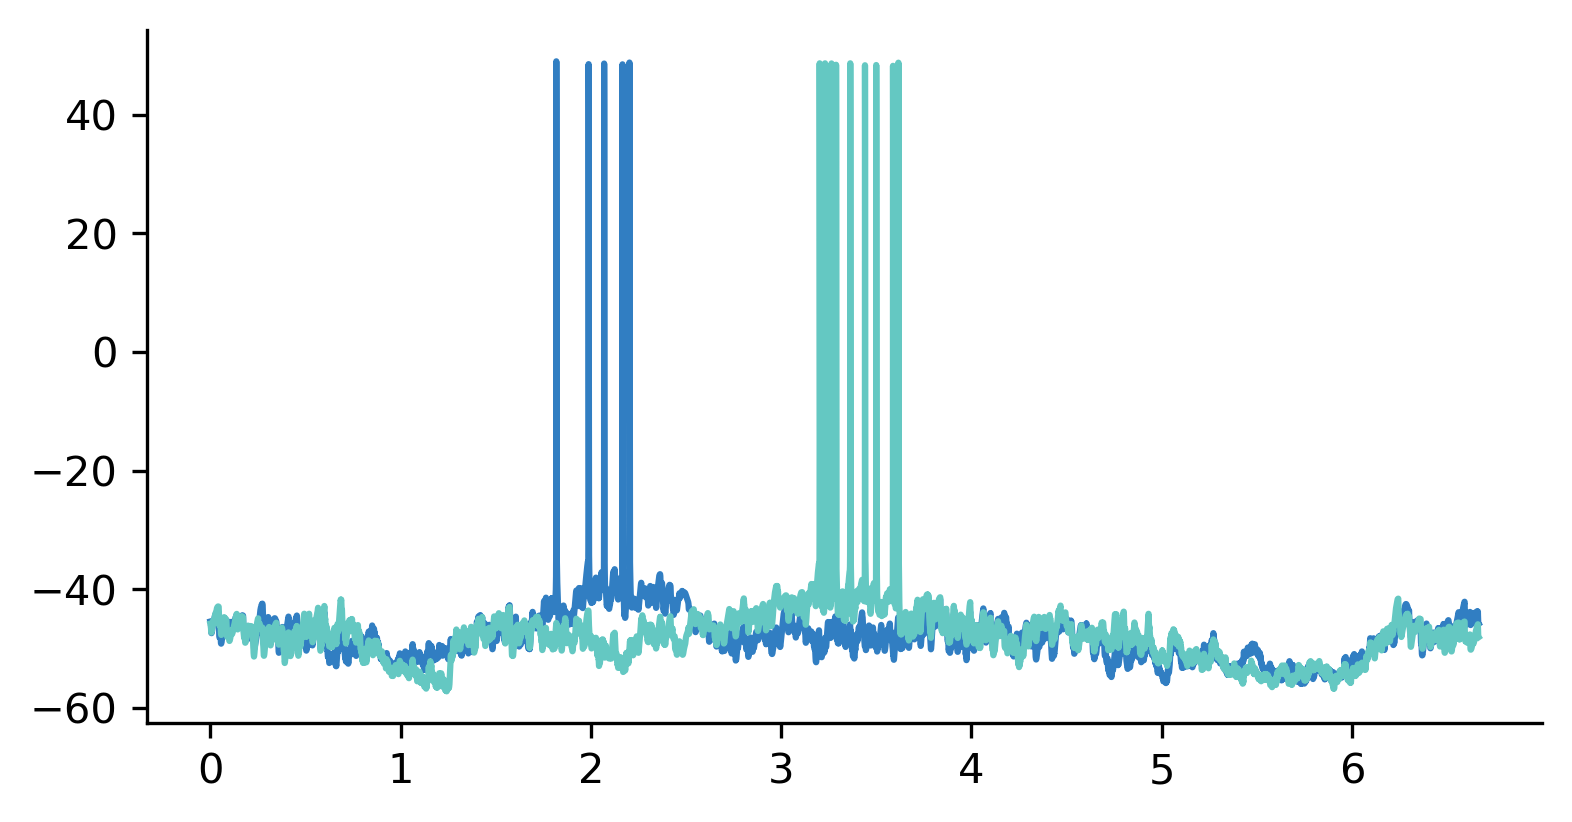

In [28]:
s = np.where(t_vec > time_for_single_lap*9+500)[0][0]
e = np.where(t_vec < time_for_single_lap*10+500)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,3), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[77][s:e], color=(49/255., 126/255., 194/255.))
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[127][s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

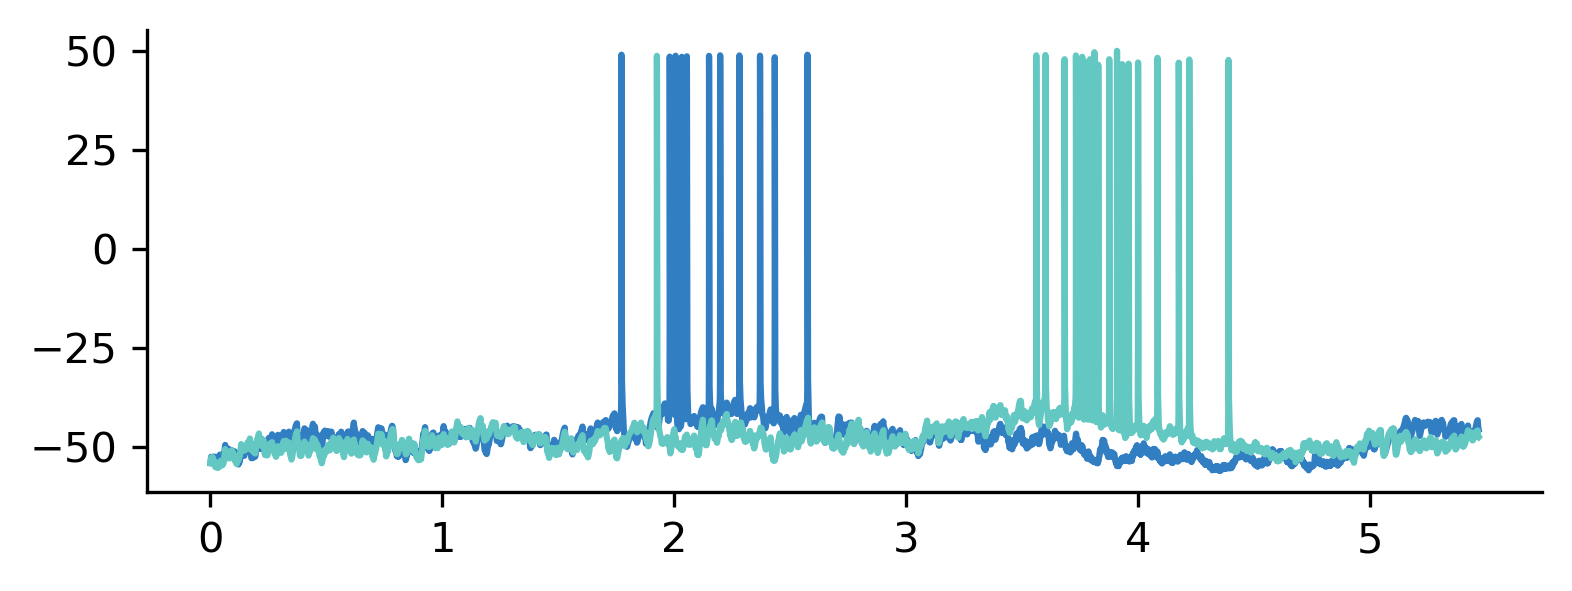

In [29]:
t_vec = np.asarray(t_vec)
s = np.where(t_vec > time_for_single_lap*9+500+1200)[0][0]
e = np.where(t_vec < time_for_single_lap*10+500+1400)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,2), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[130])[s:e], color=(49/255., 126/255., 194/255.))

plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[188])[s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

In [30]:

def restore_weights(diagram, file_path):
    pop_weights_dict = defaultdict(lambda: dict())
    saved_weights = { int(k): v for k,v in np.load(file_path).items() }
    for pop in diagram.wiring_information.keys():
        pop_id = diagram.pop2id[pop]
        ctype_offset = diagram.wiring_information[pop]['ctype offset']
        ncells = diagram.wiring_information[pop]['ncells']
        print(f"pop {pop}: ncells = {ncells}")
        for gid in range(ctype_offset, ctype_offset+ncells):
            if gid in saved_weights:
                src_gids = saved_weights[gid]['src_gids']
                
                src_gid_weights = saved_weights[gid]['weights']
                src_gid_weights_upd = saved_weights[gid]['weights_upd']
                src_gid_dict = defaultdict(list)
                for src_pop in diagram.wiring_information.keys():
                    src_pop_id = diagram.pop2id[src_pop]
                    src_ctype_offset = diagram.wiring_information[src_pop]['ctype offset']
                    src_ncells = diagram.wiring_information[src_pop]['ncells']
                    this_src_gid_idxs = np.argwhere(np.logical_and(src_gids >= src_ctype_offset,
                                                                   src_gids <= src_ctype_offset + src_ncells))[:,0]
                    
                    print(f"gid {gid}: src_pop_id {src_pop_id} src_gids = {src_gids[this_src_gid_idxs]}")
                    src_gid_dict[src_pop_id] = (src_gids[this_src_gid_idxs],
                                                src_gid_weights[this_src_gid_idxs],
                                                src_gid_weights_upd[this_src_gid_idxs])
                for src_pop in diagram.external_information.keys():
                    src_pop_id = diagram.external_pop2id[src_pop]
                    src_ctype_offset = diagram.external_information[src_pop]['ctype offset']
                    src_ncells = diagram.external_information[src_pop]['ncells']
                    this_src_gid_idxs = np.argwhere(np.logical_and(src_gids >= src_ctype_offset,
                                                                   src_gids <= src_ctype_offset + src_ncells))[:,0]
                    src_gid_dict[src_pop_id] = (src_gids[this_src_gid_idxs],
                                                src_gid_weights[this_src_gid_idxs],
                                                src_gid_weights_upd[this_src_gid_idxs])
                pop_weights_dict[pop_id][gid] = dict(src_gid_dict)
    return dict(pop_weights_dict)

In [31]:
saved_weights = restore_weights(diagram, "../params/0801-cue-ee-ei-nlaps-10-dt-zerodot1-scale-2-v1.npz")

pop ca3pyr: ncells = 260
gid 0: src_pop_id 0 src_gids = [ 1  1  3  3  4  4  6  6  7  7 10 10 11 11 12 12 13 13 16 16 19 19 21 21
 29 29 37 37 40 40]
gid 0: src_pop_id 1 src_gids = [261 262 262 266 267 267 269 269 270 270 272 278 280 285 285 286 286 287
 287 288 290 290]
gid 1: src_pop_id 0 src_gids = [  6   6   7   7   8   8   9   9  10  10  12  12  13  13  14  14  15  15
  17  17  19  19  20  20  22  22  26  26  27  27 260 260 260]
gid 1: src_pop_id 1 src_gids = [260 260 260 266 266 266 268 268 271 271 272 272 273 277 281 281 286 286
 286 287 290 290]
gid 2: src_pop_id 0 src_gids = [ 0  0  4  4  5  5  6  6  7  7  9  9 11 11 13 13 14 14 17 17 18 18 20 20
 23 23 25 25 27 27 31 31 32 32 34 34 35 35 43 43]
gid 2: src_pop_id 1 src_gids = [261 265 265 266 268 269 272 274 274 276 277 277 277 278 278 279 280 282
 285 288 290 290]
gid 3: src_pop_id 0 src_gids = [  0   0   5   5   7   7   9   9  10  10  11  11  12  12  13  13  15  15
  16  16  17  17  18  18  26  26  29  29  33  33  34  34  36 

In [32]:
len(saved_weights[1].keys())

30

In [33]:
def saved_weight_change(weights_dict, src_id, dst_id, valid_gids=None):
    
    weight_before, weight_after = [], []

    this_weights_dict = weights_dict[dst_id]
    for dst_gid in this_weights_dict.keys():
        if valid_gids is not None and dst_gid not in valid_gids:
            continue
        if src_id not in this_weights_dict[dst_gid]: 
            continue
        src_gids, connection_weights, connection_weights_upd = this_weights_dict[dst_gid][src_id]
        has_updated_weights = len(~np.isnan(connection_weights_upd)) > 0
        for i, src_gid in enumerate(src_gids):
            if has_updated_weights and not np.isnan(connection_weights_upd[i]):
                weight_before.append(connection_weights[i])
                weight_after.append(connection_weights_upd[i])
            else:
                weight_before.append(connection_weights[i])
                weight_after.append(connection_weights[i])
    pchange = []
    for (b,a) in zip(weight_before, weight_after):
        pchange.append((a-b)/(b+1.0e-9))
        
    return weight_before, weight_after, pchange


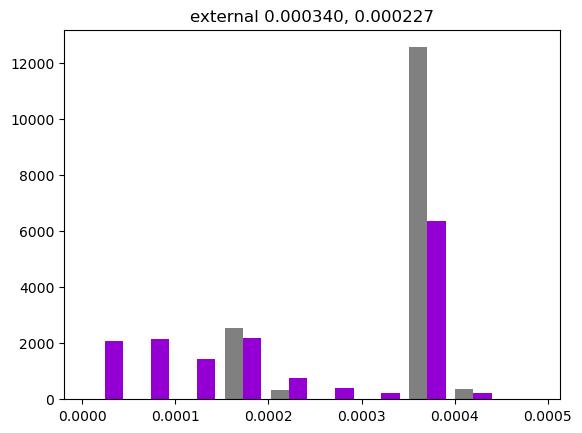

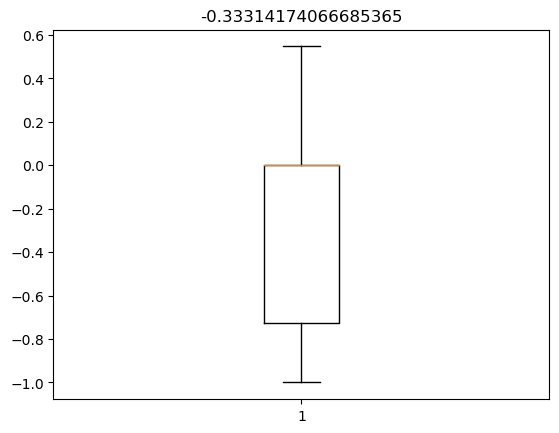

In [34]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 100, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



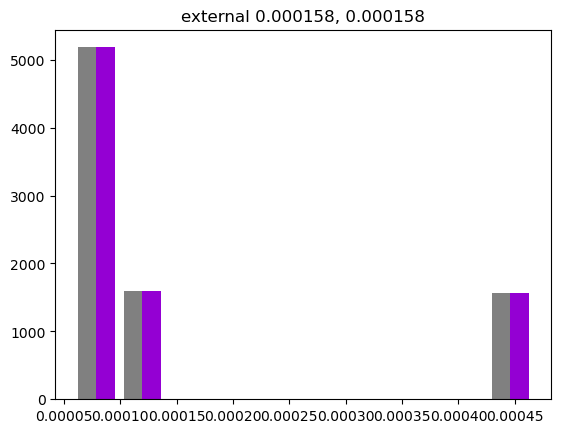

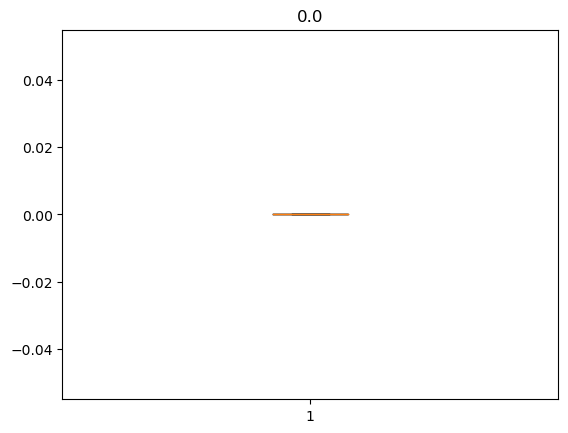

In [35]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 102, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



0.0074255657


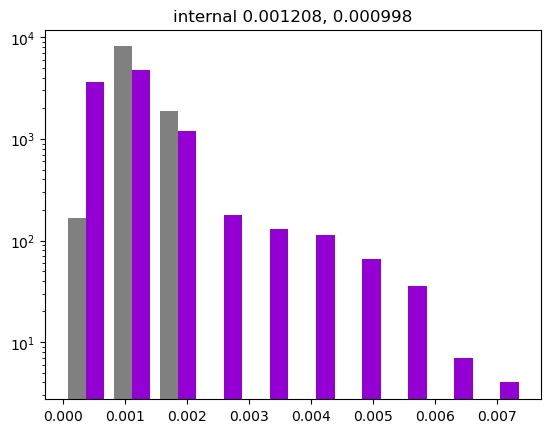

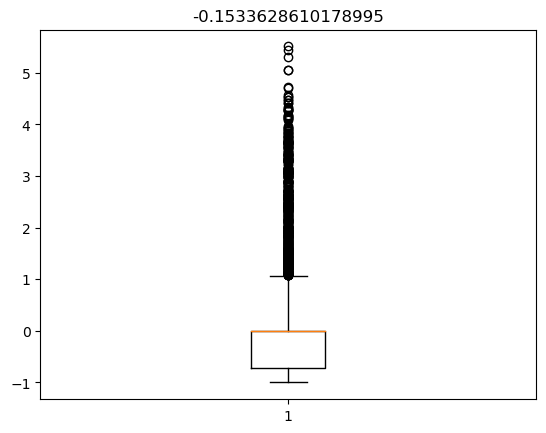

internal 0
0.41333345


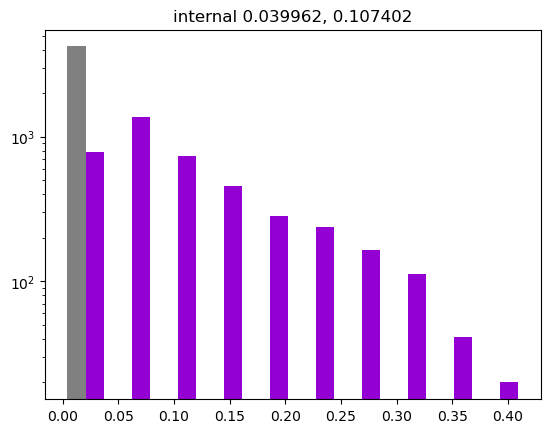

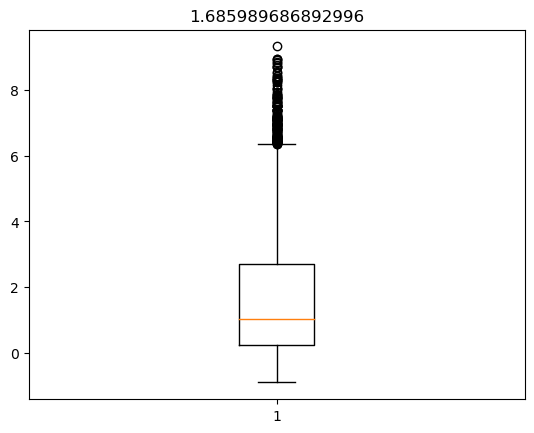

In [36]:
scale = 2

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0)
                                                                        
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 1)
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

In [37]:
def spike_bins(spike_times, start, finish, binsize=100, gids=None):
    
    bins = np.arange(start, finish, binsize)
    nbins = len(bins)+1
    nspikes = np.zeros((nbins,),dtype=np.uint32)
    for (gid,sts) in spike_times.items():
        if (gids is not None) and (gid not in gids):
            continue
        sts = np.asarray(sts)
        this_ibins = np.digitize(sts, bins)
        for ibin in this_ibins:
            nspikes[ibin] += 1
            
    return nspikes
    
def plot_spikes(spike_times, title, start, finish, gids=None):
    
    frs = []
    plt.figure(figsize=(12,2))
    i = 0
    for (gid,sts) in spike_times.items():
        if (gids is not None) and (gid not in gids):
            continue
        sts = np.asarray(sts)
        plt.vlines(np.asarray(sts), i+0.5, i+1.5)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        i += 1
    plt.xlim([start, finish])
    plt.title('%s fr. mean: %0.3f. std: %0.3f' % (title, np.mean(frs), np.std(frs)))
    plt.show()
    return
    

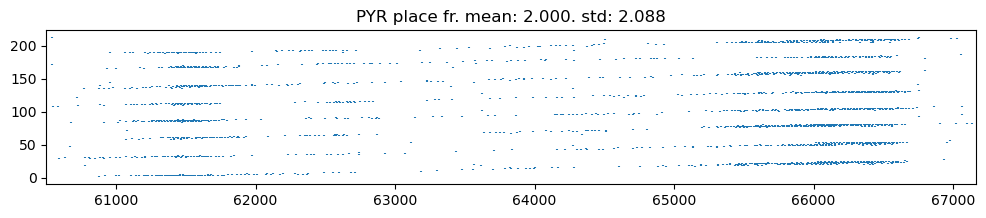

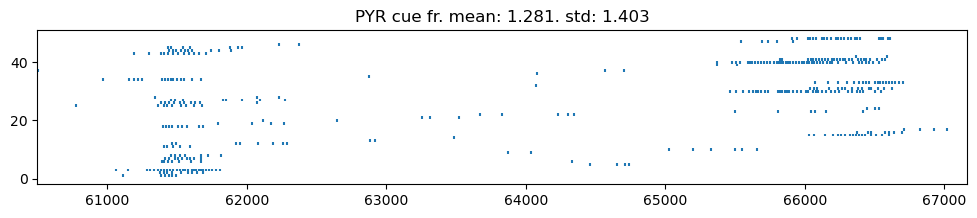

In [38]:

cell_spike_times = np.load("../data/cell_spikes_0801-cue-ee-ei-nlaps-10.npz")
cell_spike_times = { int(gid): v for gid, v in cell_spike_times.items() }
start  = time_for_single_lap * 9. + 500
finish = time_for_single_lap * 10. + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'])
plot_spikes(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'])

#plot_spikes(circuit, 0, 'exa,ple cue', start, finish, gids=[cue_cells[4]])

#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130*2))
#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=None)

    

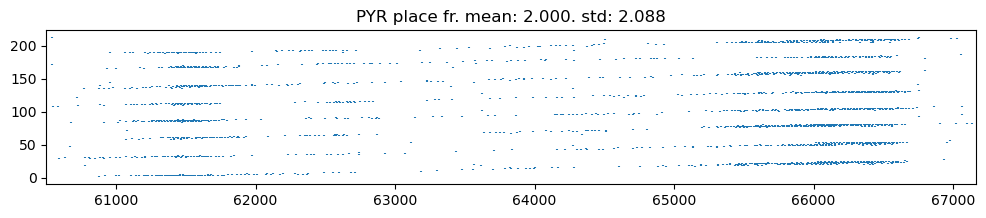

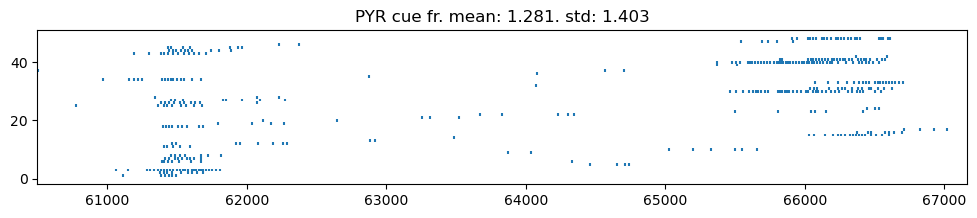

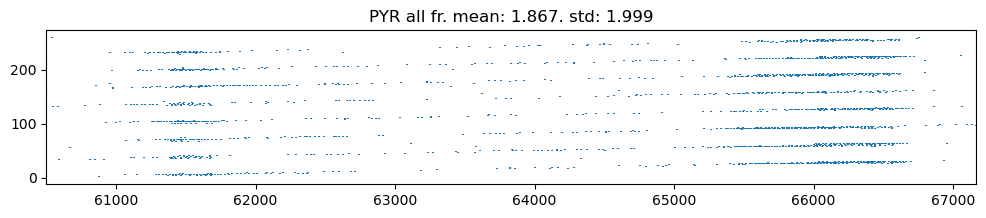

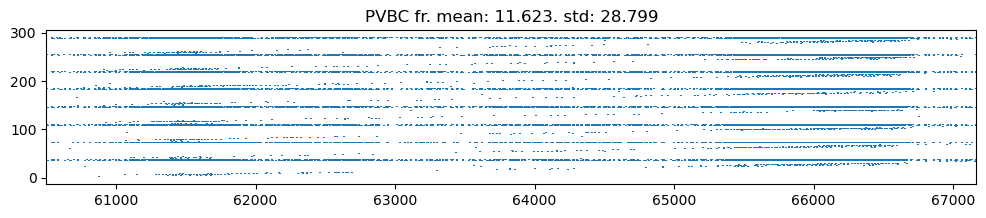

68
place-cue corr PearsonRResult(statistic=0.9995441131509463, pvalue=4.610214103522722e-102)
place-pvbc corr PearsonRResult(statistic=0.9998443639236694, pvalue=1.8327460087830634e-117)
pvbc-cue corr PearsonRResult(statistic=0.9991812045289246, pvalue=1.1318240232578331e-93)


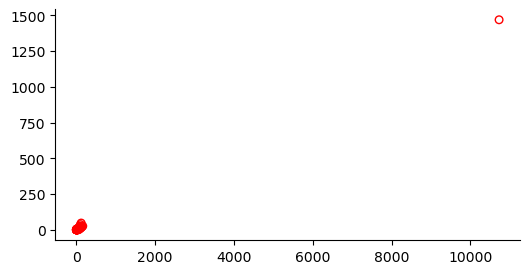

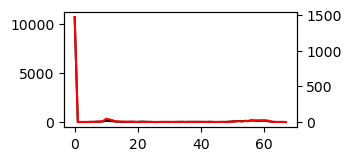

r,p 0.7462916329984962 2.7897920628511215e-13


In [39]:


start  = time_for_single_lap * 9 + 500
finish = time_for_single_lap * 10 + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, diagram.place_information[0]['place'])
plot_spikes(cell_spike_times, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*2))
plot_spikes(cell_spike_times, 'PVBC', start, finish)

nspikes_place = spike_bins(cell_spike_times, start, finish, gids=diagram.place_information[0]['place'])
nspikes_cue   = spike_bins(cell_spike_times, start, finish, gids=diagram.place_information[0]['not place'])
nspikes_total = spike_bins(cell_spike_times, start, finish, gids=np.arange(130*2))
nspikes_pvbc  = spike_bins(cell_spike_times, start, finish)


from scipy.stats import pearsonr, spearmanr
print(len(nspikes_place))
print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

#(6,3)
fig = plt.figure(figsize=(6,3))
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='red',s=30)
# plt.xlabel('number place cells spikes')
# plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(3,1.5))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p)

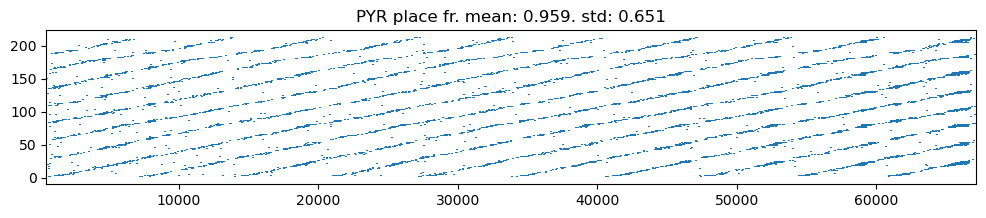

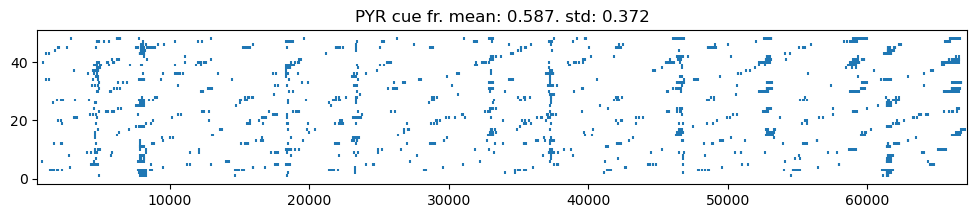

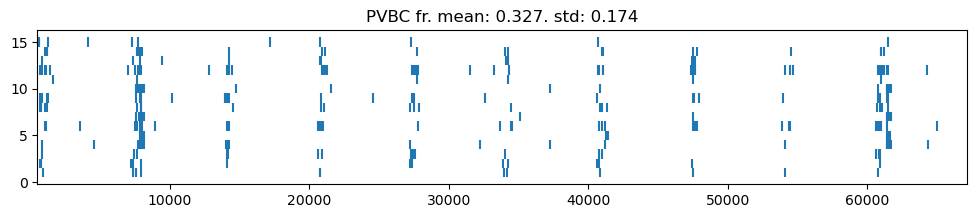

In [40]:
start  = time_for_single_lap * 0. + 500
finish = time_for_single_lap * 10. + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'])#, color=(49/255.,126/255.,194/255.))
plot_spikes(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'])#, color=(231/255.,135/255.,43/255.))
#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130))
plot_spikes(cell_spike_times, 'PVBC', start, finish, gids=np.arange(15))#, color=(224/255.,127/255., 128/255.))

#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=np.arange(130,145))

# plot_spikes(circuit, 2, 'AAC', start, finish)
# plot_spikes(circuit, 3, 'BiS', start, finish)
# plot_spikes(circuit, 4, 'OLM', start, finish)
# plot_spikes(circuit, 5, 'ISCCR', start, finish)
    

2.2609399438927933 0.024596354622904354


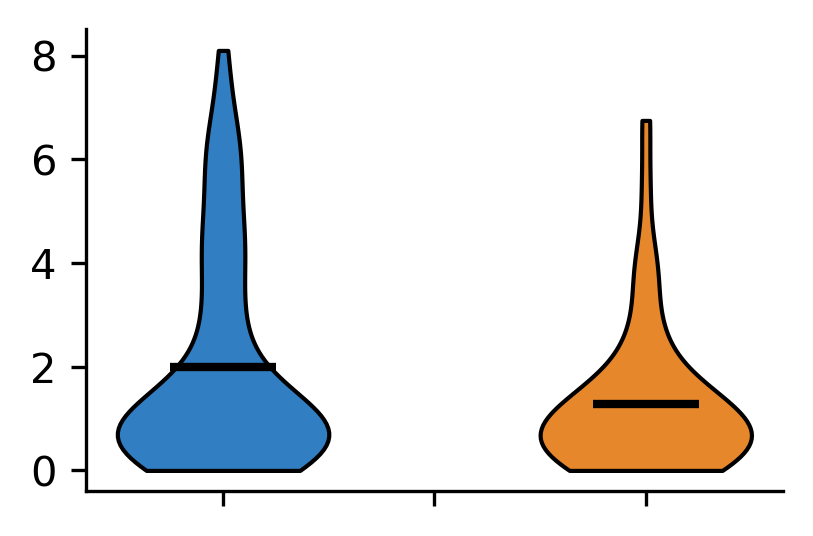

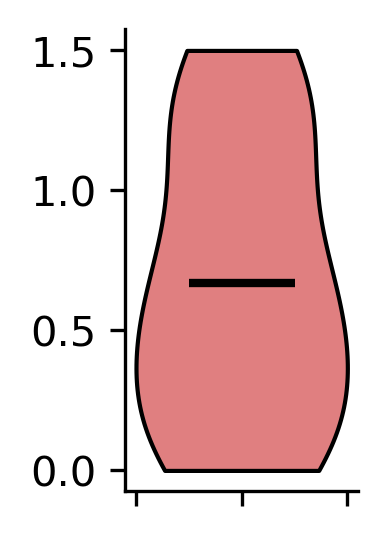

In [41]:
from scipy.stats import ttest_ind

def get_pop_frs(spike_times, title, start, finish, gids=None, color='k'):
    
    frs = []
    for (gid,sts) in spike_times.items():
        if gid not in gids:
            continue
        sts = np.divide(np.asarray(sts), 1000.)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        
    return frs

start  = time_for_single_lap * 9 + 500
finish = time_for_single_lap * 10 + 500

colors = [(49/255.,126/255.,194/255.), (231/255.,135/255.,43/255.), (224/255.,127/255., 128/255.)]

place_frs = get_pop_frs(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
cue_frs   = get_pop_frs(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
int_frs   = get_pop_frs(cell_spike_times, 'PVBC', start, finish, gids=np.arange(0,15))

t, p = ttest_ind(place_frs, cue_frs)
print(t,p)

fig = plt.figure(dpi=300, figsize=(3,2))
ax = fig.gca()
vplot = plt.violinplot([place_frs, cue_frs], showextrema=False, showmeans=True, positions=[0,1])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

#####
colors = [(224/255.,127/255., 128/255.)]

fig = plt.figure(dpi=300, figsize=(1,2))
ax = fig.gca()
vplot = plt.violinplot([int_frs], showextrema=False, showmeans=True, positions=[0])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

In [52]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd = cell_info[1]
    weights = connection_weights + connection_weights_upd
    print(src_gids)
    print(weights)
    pvbc_to_place_weights.append(weights)

pvbc_to_place_weights = np.concatenate(pvbc_to_place_weights)            
            
pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = saved_weights[0][pgid]
    
    src_gids, connection_weights, connection_weights_upd = cell_info[1]
    weights = connection_weights + connection_weights_upd
    pvbc_to_notplace_weights.append(weights)
            
pvbc_to_notplace_weights = np.concatenate(pvbc_to_notplace_weights)            
            
print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
fig = plt.figure()
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=['silver', 'darkviolet'], 
         density=True, edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, p2 = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(u, p2)

[261 262 262 266 267 267 269 269 270 270 272 278 280 285 285 286 286 287
 287 288 290 290]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00041068        nan]
[260 260 260 266 266 266 268 268 271 271 272 272 273 277 281 281 286 286
 286 287 290 290]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00041399        nan]
[260 260 262 263 263 263 263 268 268 269 270 271 272 272 272 277 279 280
 284 289 290 290]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.0003911

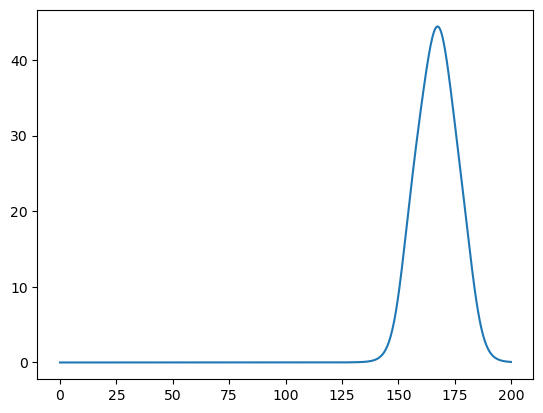

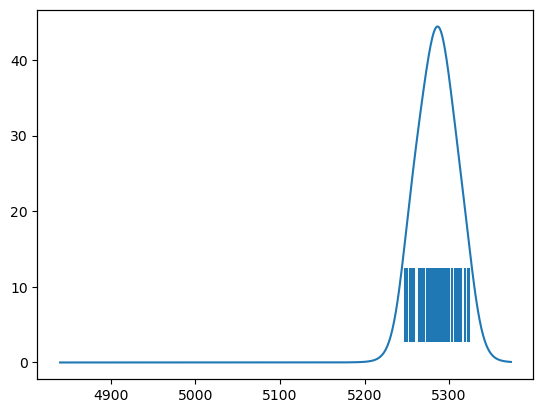

In [43]:
all_exc_frs = {}
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 9 + 500
end_time   = time_for_single_lap * 10 + 500

#for i in circuit.neurons[0].keys():
for gid in place_cells:
    exc_spikes = cell_spike_times[gid]

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)
    if len(exc_spikes) == 0:
        all_exc_frs[gid] = np.zeros_like(estimated_times)
    else:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs[gid] = estimated_fr
        valid_gids.append(gid)

all_exc_frs_array = np.vstack([ exc_frs for exc_frs in all_exc_frs.values() ])

idx = 167
plt.figure()
#plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs_array[idx])

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs_array[idx])
ax2 = ax.twinx()
#ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.vlines(all_exc_spikes[idx]/step, 0.5, 1.5)

ax2.set_ylim([0, 5])
ax2.set_yticks([])
plt.show();


19.05517380708114582 18.639624711376308198


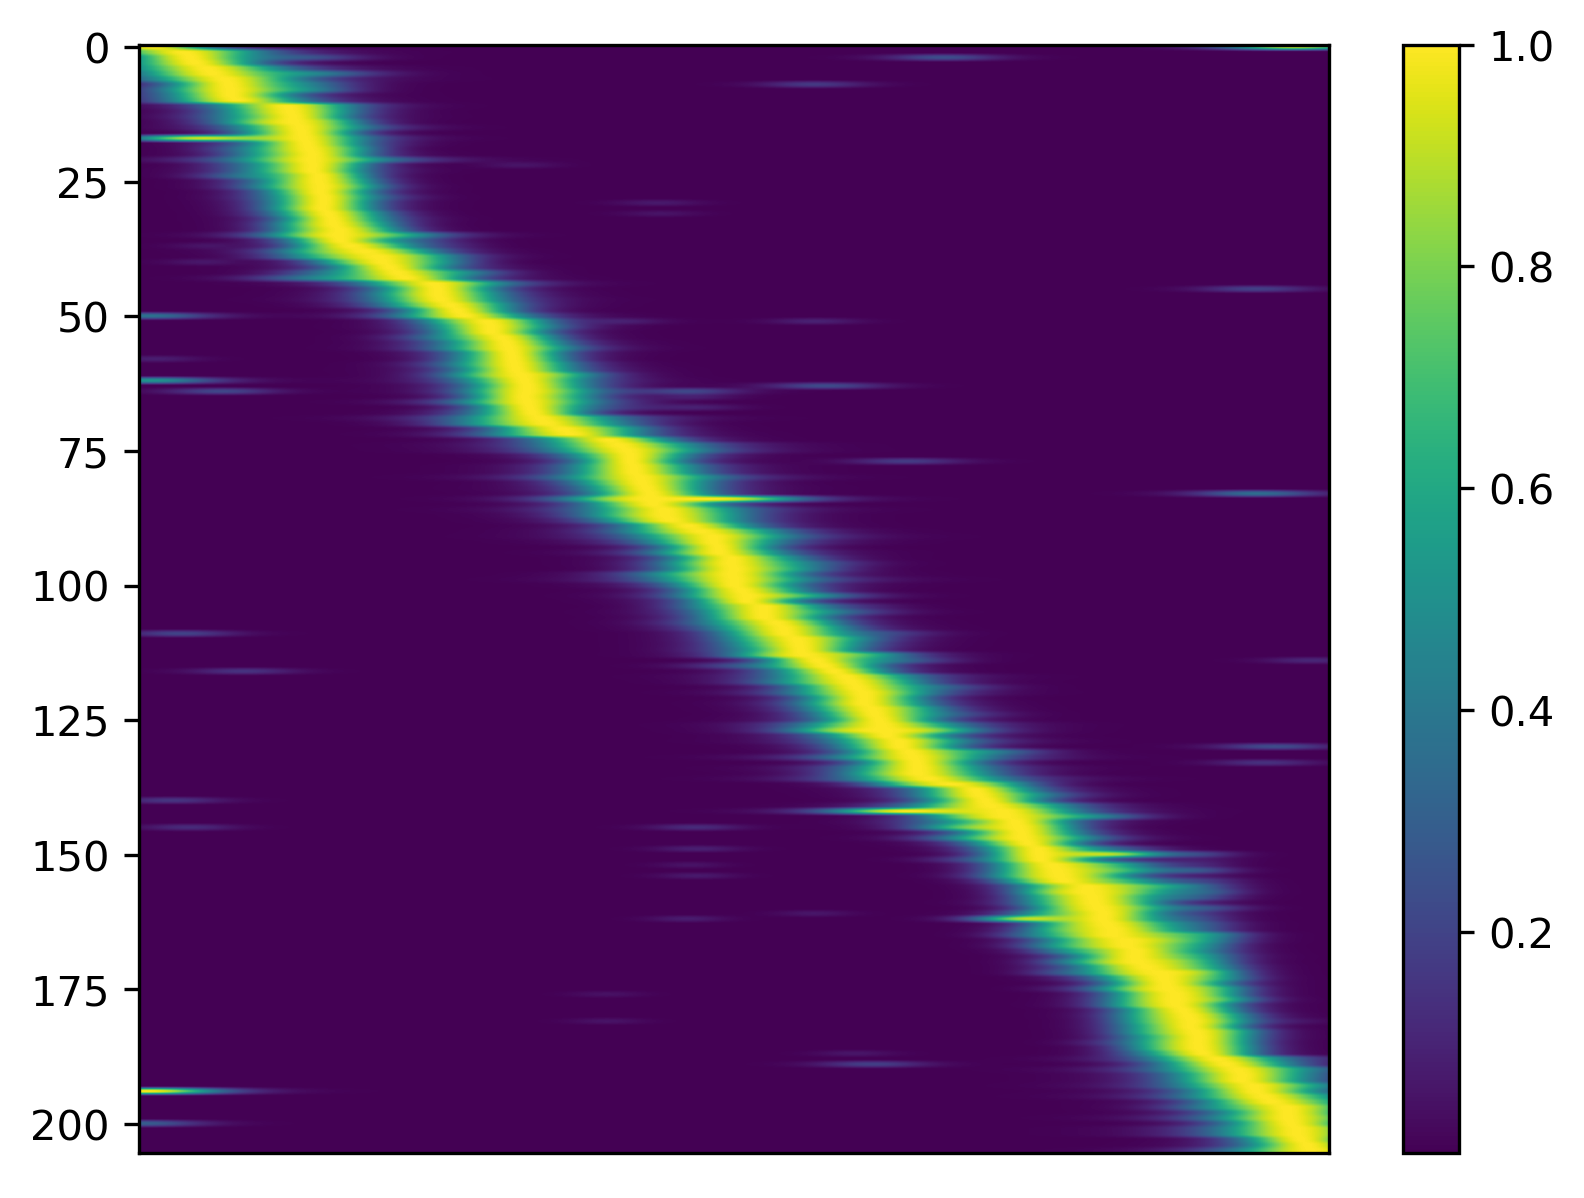

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


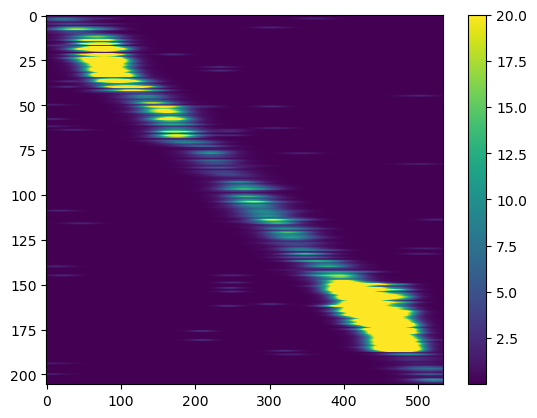

{0, 1, 2}


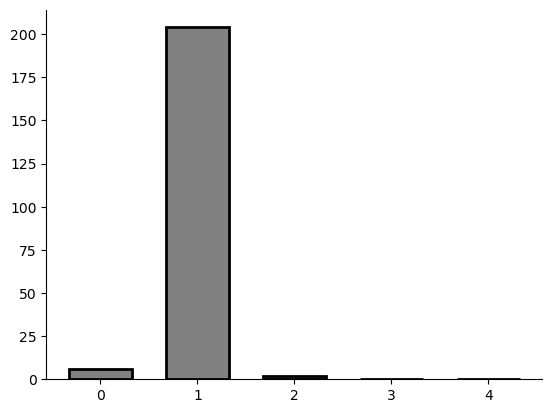

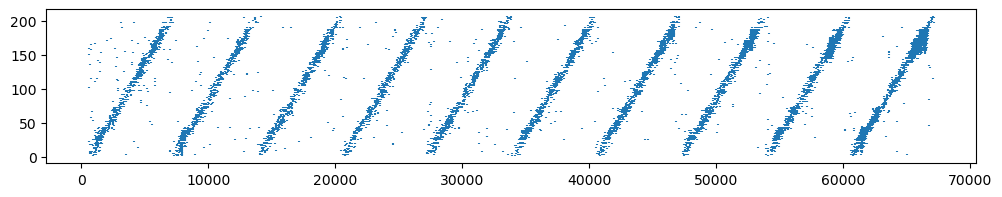

In [44]:


# valid_idxs = []
# invalid_idxs = []
# for i in range(len(all_exc_frs)):
#     sl = all_exc_frs[i]
#     if not np.all(sl < 10.0): valid_idxs.append(i)
#     else: 
#         invalid_idxs.append(i)

#valid_idxs = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
#valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
valid_exc_frs = np.vstack([all_exc_frs[valid_gid] for valid_gid in valid_gids])
max_frs = valid_exc_frs.max(axis=1)
print(max_frs.mean(), max_frs.std())


normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure(dpi=300)
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.show()

plt.figure()
plt.imshow(valid_exc_frs_sorted, cmap='viridis', aspect='auto', vmax=20)
plt.colorbar()
plt.show()





# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
fig = plt.figure()
ax = fig.gca()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

valid_raster = []
for nid in np.asarray(valid_gids)[sorted_max]:
    valid_raster.append(cell_spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()



In [180]:
# weight matrix
def create_adj_matrix(circuit, src_cells, dst_cells):
    Nsrc = len(src_cells)
    Ndst = len(dst_cells)
    adj_matrix = np.zeros((Ndst,Nsrc), dtype='float32')
    
    for (cidx, cell) in enumerate(dst_cells):
        presynaptic_inputs = circuit.neurons[0][cell].internal_netcons
        for presynaptic_gid, nc, _ in presynaptic_inputs:
            if presynaptic_gid not in src_cells: continue
            try:
                pre_loc = list(src_cells).index(presynaptic_gid)
            except:
                continue
            nc = nc[0]
            weight = nc.weight[0] + nc.weight[1]
            
            adj_matrix[cidx, pre_loc] = weight
    return adj_matrix

place_cells = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
cue_cells = diagram.place_information[0]['not place']
print(place_cells)
adj_matrix = create_adj_matrix(circuit, place_cells, place_cells)
valid_vals = []
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i,j] > 0.0: valid_vals.append(adj_matrix[i,j])
cutoff = np.percentile(valid_vals, 0.)
adj_matrix[adj_matrix <= cutoff] = None



plt.figure(figsize=(4,4))
plt.imshow(adj_matrix, cmap='inferno', vmin=0.000, aspect='auto', vmax=0.0250)
# plt.xlabel('presynaptic')
# plt.ylabel('postsynaptic')
#plt.colorbar()
plt.show()



[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]


NameError: name 'circuit' is not defined

In [59]:
# motif analysis on place and non-place fields
# place_cells = place_cells
non_place_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']

pvbc_gids = np.arange(130, 145)

place_weights, nonplace_weights = [], []
for pvbc_gid in circuit.neurons[1].keys():
    pvbc_info = circuit.neurons[1][pvbc_gid].internal_netcons
    for (presynaptic_gid, nc, _) in pvbc_info:
        if presynaptic_gid in place_cells:
            try:
                weight = nc[0].weight[0] + nc[0].weight[1]
                place_weights.append(weight)
            except: continue
        elif presynaptic_gid in non_place_cells:
            try:
                weight = nc[0].weight[0] + nc[0].weight[1]
                nonplace_weights.append(weight)
            except: continue
                
fig = plt.figure()
ax  = fig.gca()
plt.hist([place_weights, nonplace_weights], color=['silver', 'darkviolet'], edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(place_weights))
print('nonplace median', np.median(nonplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(place_weights, nonplace_weights)
print(t, p)

place median 0.12124687857572089
nonplace median 0.3111170769442464
-64.29973729143033 0.0


In [60]:
non_place_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130 and presynaptic_gid < 145:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_place_weights.append(weight)

pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130 and presynaptic_gid < 145:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_to_notplace_weights.append(weight)      
        
fig = plt.figure(figsize=(4,4))
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=3)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

place median 0.0021477013082927886
nonplace median 0.003052245728150517
-6.592958396694211 1.847917690376764e-10


[0.14104701513286808, 0.1751729376585422, 0.22356841435973868, 0.32622138773033443, 0.15490731064446517, 0.1469071370738496, 0.1226341218402964, 0.1226341218402964, 0.22174243184230383, 0.2136860887709641, 0.11391968738605715, 0.25179039363805666, 0.25179039363805666, 0.2206177566948094, 0.2206177566948094, 0.2630626588051721, 0.16039769177582078, 0.3580249771719837, 0.3580249771719837, 0.2789193262884765, 0.12344709380209956, 0.24533379917084153, 0.24533379917084153, 0.1962948065617596, 0.1962948065617596, 0.11413869365091617, 0.11413869365091617, 0.25064122672886463, 0.26614625269281283, 0.24802227281988343, 0.34793085356023956, 0.2749920462864658, 0.12755946862785938, 0.12666746635726103, 0.21363122695924, 0.2314916388251781, 0.21507863399037253, 0.21507863399037253, 0.26593560028866253, 0.31994172081502376, 0.31994172081502376, 0.2496590005893113, 0.2487387853612345, 0.2547410160110916, 0.1405291974367624, 0.1861327359807257, 0.2032985124324476, 0.1071594580907193, 0.18216684362425

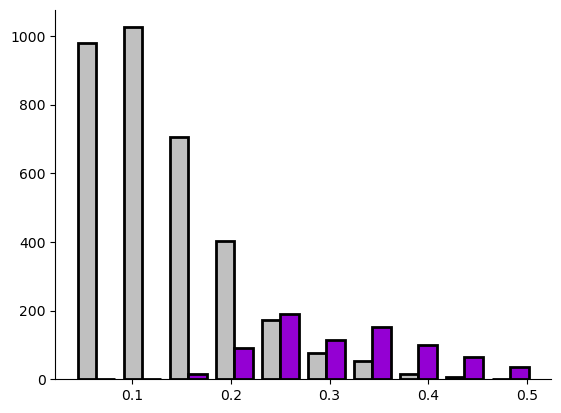

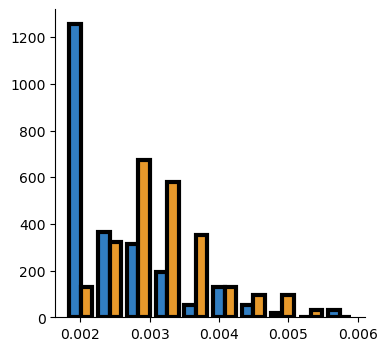

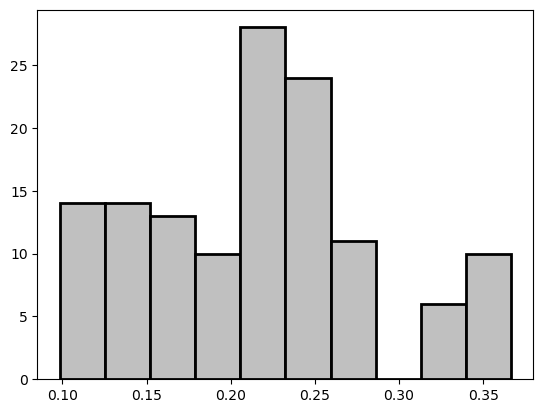

In [61]:
pvbc_gids = np.arange(130, 145)
pvbc_recurrent_weights = []
for pvbcgid in np.arange(0,15):
    cell_info = circuit.neurons[1][pvbcgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid in pvbc_gids:
            weight = nc[0].weight[0] + nc[0].weight[1]
            pvbc_recurrent_weights.append(weight)

            
print(pvbc_recurrent_weights)
plt.figure()
plt.hist([pvbc_recurrent_weights], color=['silver'], edgecolor='k', linewidth=2)
plt.show()